# Mini Project 5 – LendingClub Default Prediction
Author: Rishi Rakesh Urs, Arjun Iyer, Alvaro Crawford, Alhaji Jalloh

This notebook:
- Loads and combines the four LendingClub CSV files (`LoanStats3a_securev1.csv`–`3d`)
- Applies the same cleaning logic as Project 4 (plus dropping leakage & ID columns)
- Creates a binary default target from `loan_status`
- Trains Random Forest, AdaBoost, XGBoost, and an ANN
- Runs a sensitivity analysis dropping FICO and/or grade features.

In [48]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    average_precision_score,  # PR AUC
)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from tensorflow import keras
from tensorflow.keras import layers

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 180)

## 1. Load and combine LendingClub CSV files

In [49]:
def load_lendingclub_csv(path):
    """Load a LendingClub CSV that has metadata rows before the real header.
    
    We scan for the line where the header row starts (begins with 'id' or "id").
    """
    with open(path, "r", encoding="utf-8") as f:
        lines = f.readlines()

    header_index = None
    for i, line in enumerate(lines):
        if line.startswith('"id"') or line.startswith("id,"):
            header_index = i
            break

    if header_index is None:
        raise ValueError(f"Could not find header row in file {path}")

    print(f"Detected header at line {header_index} for file {path}")
    return pd.read_csv(path, skiprows=header_index, low_memory=False)


# ---- Load all 4 CSVs ----
files = [
    "LoanStats3a_securev1.csv",
    "LoanStats3b_securev1.csv",
    "LoanStats3c_securev1.csv",
    "LoanStats3d_securev1.csv",
]

dfs = []
for f in files:
    df_tmp = load_lendingclub_csv(f)
    dfs.append(df_tmp)

loan_data = pd.concat(dfs, ignore_index=True)
print("Combined shape:", loan_data.shape)
loan_data.head()

Detected header at line 1 for file LoanStats3a_securev1.csv
Detected header at line 1 for file LoanStats3b_securev1.csv
Detected header at line 1 for file LoanStats3c_securev1.csv
Detected header at line 1 for file LoanStats3d_securev1.csv
Combined shape: (887391, 115)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,735.0,739.0,1.0,NaN,NaN,3.0,0.0,13648.0,83.7%,9.0,f,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-2015,171.62,NaN,Feb-2016,719.0,715.0,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,740.0,744.0,5.0,NaN,NaN,3.0,0.0,1687.0,9.4%,4.0,f,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,534.0,530.0,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,735.0,739.0,2.0,NaN,NaN,2.0,0.0,2956.0,98.5%,10.0,f,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-2014,649.91,NaN,Feb-2016,679.0,675.0,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-1996,690.0,694.0,1.0,35.0,NaN,10.0,0.0,5598.

## 2. Drop ID, text, leakage, and policy columns

In [50]:
cols_to_drop = [
    # Identifiers
    "id", "member_id", "url", "title",
    # Text / high-cardinality
    "desc", "emp_title",
    # Location (keep state if you want; we drop zipcode)
    "zip_code",
    # Leakage / post-origination behaviour
    "out_prncp", "out_prncp_inv",
    "total_pymnt", "total_pymnt_inv",
    "total_rec_prncp", "total_rec_int",
    "total_rec_late_fee", "recoveries", "collection_recovery_fee",
    "last_pymnt_d", "last_pymnt_amnt",
    "next_pymnt_d",
    # Other date-like columns we won't model directly
    "acceptD", "Application Date", "listD", "reviewStatusD",
    "expD", "expDefaultRate", "creditPullD", "ils_exp_d",
    # Policy / internal flags (names vary across vintages)
    "Policy Code", "policy_code",
    "reviewStatus",
]

loan_data = loan_data.drop(columns=[c for c in cols_to_drop if c in loan_data.columns])
print("Shape after column drop:", loan_data.shape)
loan_data.head()

Shape after column drop: (887391, 95)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,credit_card,AZ,27.65,0.0,Jan-1985,735.0,739.0,1.0,NaN,NaN,3.0,0.0,13648.0,83.7%,9.0,f,Feb-2016,719.0,715.0,0.0,NaN,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,car,GA,1.00,0.0,Apr-1999,740.0,744.0,5.0,NaN,NaN,3.0,0.0,1687.0,9.4%,4.0,f,Sep-2013,534.0,530.0,0.0,NaN,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,small_business,IL,8.72,0.0,Nov-2001,735.0,739.0,2.0,NaN,NaN,2.0,0.0,2956.0,98.5%,10.0,f,Feb-2016,679.0,675.0,0.0,NaN,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,other,CA,20.00,0.0,Feb-1996,690.0,694.0,1.0,35.0,NaN,10.0,0.0,5598.0,21%,37.0,f,Jan-2015,579.0,575.0,0.0,NaN,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,other,OR,17.94,0.0,Jan-1996,695.0,699.0,0.0,38.0,NaN,15.0,0.0,27783.0,53.9%,38.0,f,Feb-2016,674.0,670.0,0.0,NaN,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


## 3. Feature engineering and encoding

In [51]:
# --- term: 36 vs 60 months ---
if "term" in loan_data.columns:
    loan_data["term_36"] = loan_data["term"].astype(str).str.contains("36").astype(int)
    loan_data = loan_data.drop(columns=["term"])

# --- interest rate: strip % and convert to float ---
if "int_rate" in loan_data.columns and loan_data["int_rate"].dtype == "object":
    loan_data["int_rate"] = loan_data["int_rate"].str.rstrip("%").astype(float)

# --- revol_util: strip % and convert to float ---
if "revol_util" in loan_data.columns and loan_data["revol_util"].dtype == "object":
    loan_data["revol_util"] = loan_data["revol_util"].str.rstrip("%").astype(float)

# --- employment length -> numeric years ---
if "emp_length" in loan_data.columns:
    emp_length_map = {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "n/a": np.nan,
    }
    loan_data["emp_length_num"] = loan_data["emp_length"].map(emp_length_map)
    loan_data = loan_data.drop(columns=["emp_length"])

# --- earliest_cr_line & issue_d -> credit history length ---
if "earliest_cr_line" in loan_data.columns:
    loan_data["earliest_cr_line"] = pd.to_datetime(
        loan_data["earliest_cr_line"], format="%b-%Y", errors="coerce"
    )
if "issue_d" in loan_data.columns:
    loan_data["issue_d"] = pd.to_datetime(
        loan_data["issue_d"], format="%b-%Y", errors="coerce"
    )

if "earliest_cr_line" in loan_data.columns and "issue_d" in loan_data.columns:
    loan_data["credit_history_yrs"] = (
        (loan_data["issue_d"] - loan_data["earliest_cr_line"]).dt.days / 365.25
    )
    loan_data = loan_data.drop(columns=["earliest_cr_line"])

# --- last_credit_pull_d recency ---
if "last_credit_pull_d" in loan_data.columns and "issue_d" in loan_data.columns:
    loan_data["last_credit_pull_d"] = pd.to_datetime(
        loan_data["last_credit_pull_d"], format="%b-%Y", errors="coerce"
    )
    loan_data["last_credit_pull_recency_yrs"] = (
        (loan_data["issue_d"] - loan_data["last_credit_pull_d"]).dt.days / 365.25
    )
    loan_data = loan_data.drop(columns=["last_credit_pull_d"])

# We no longer need the raw issue_d column
if "issue_d" in loan_data.columns:
    loan_data = loan_data.drop(columns=["issue_d"])

# --- One-hot encode key categoricals (Project4-style) ---
def safe_get_dummies(df, col):
    if col in df.columns:
        df[col] = df[col].fillna("Missing")
        return pd.get_dummies(df, columns=[col], drop_first=True)
    return df

for col in [
    "grade",
    "sub_grade",
    "home_ownership",
    "verification_status",
    "purpose",
    "initial_list_status",
    "application_type",
    "verification_status_joint",
]:
    loan_data = safe_get_dummies(loan_data, col)

print("Shape after feature engineering:", loan_data.shape)
loan_data.head()


Shape after feature engineering: (887391, 158)


,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,loan_status,pymnt_plan,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,...,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,sub_grade_Missing,home_ownership_MORTGAGE,home_ownership_Missing,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_f,initial_list_status_w,application_type_JOINT,application_type_Missing,verification_status_joint_Not Verified,verification_status_joint_Source Verified,verification_status_joint_Verified
0,5000.0,5000.0,4975.0,10.65,162.87,24000.0,Fully Paid,n,AZ,27.65,0.0,735.0,739.0,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,719.0,715.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
1,2500.0,2500.0,2500.0,15.27,59.83,30000.0,Charged Off,n,GA,1.00,0.0,740.0,744.0,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,534.0,530.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2,2400.0,2400.0,2400.0,15.96,84.33,12252.0,Fully Paid,n,IL,8.72,0.0,735.0,739.0,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,679.0,675.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False
3,10000.0,10000.0,10000.0,13.49,339.31,49200.0,Fully Paid,n,CA,20.00,0.0,690.0,694.0,1.0,35.0,NaN,10.0,0.0,559

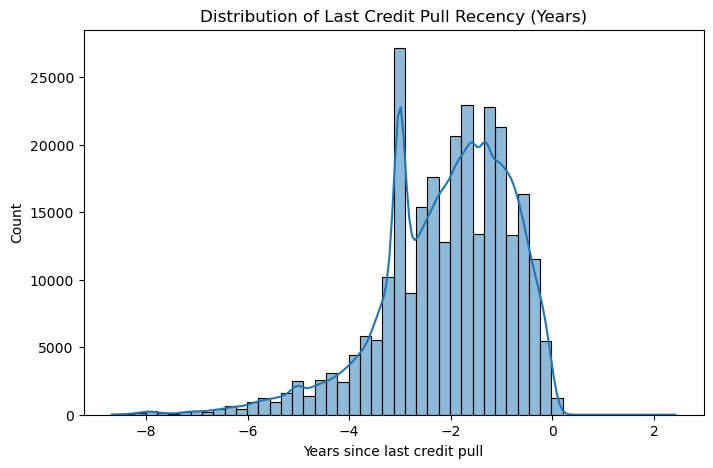

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop missing values for clean plotting
vals = loan_data["last_credit_pull_recency_yrs"].dropna()

plt.figure(figsize=(8,5))
sns.histplot(vals, bins=50, kde=True)

plt.title("Distribution of Last Credit Pull Recency (Years)")
plt.xlabel("Years since last credit pull")
plt.ylabel("Count")

plt.show()



## 4. Target definition and row filtering

In [52]:
# Drop rows with missing loan_status
loan_data = loan_data[~loan_data["loan_status"].isna()].copy()

# Bad (default-like) statuses
bad_status = [
    "Charged Off",
    "Default",
    "Does not meet the credit policy. Status:Charged Off",
]

# Keep only a focused set of final statuses
keep_status = bad_status + [
    "Fully Paid",
    "Does not meet the credit policy. Status:Fully Paid",
]
loan_data = loan_data[loan_data["loan_status"].isin(keep_status)].copy()

# Binary target: 1 = bad / default, 0 = good / fully paid
loan_data["loan_status"] = loan_data["loan_status"].apply(
    lambda x: 1 if x in bad_status else 0
)

print(loan_data["loan_status"].value_counts())
loan_data[["loan_status"]].head()

loan_status
0    225330
1     51346
Name: count, dtype: int64


,loan_status
0,0
1,1
2,0
3,0
5,0


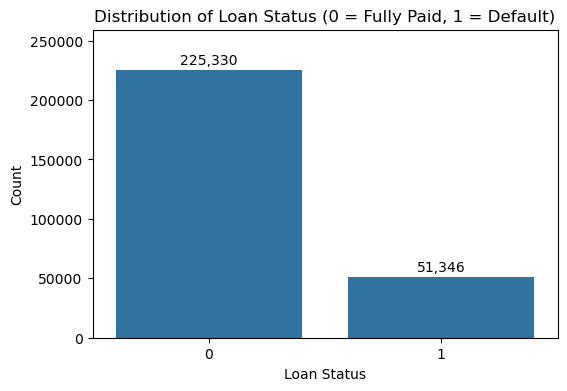

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

status_counts = loan_data["loan_status"].value_counts().sort_index()

plt.figure(figsize=(6,4))
sns.barplot(x=status_counts.index, y=status_counts.values)

plt.title("Distribution of Loan Status (0 = Fully Paid, 1 = Default)")
plt.xlabel("Loan Status")
plt.ylabel("Count")

# Add more space above the tallest bar
plt.ylim(0, status_counts.max() * 1.15)

# Annotate values
for i, v in enumerate(status_counts.values):
    plt.text(i, v + (status_counts.max() * 0.02), f"{v:,}", ha='center')

plt.show()


## 5. Build feature matrix X and target y

In [53]:
# 5. Build feature matrix X and target y

# Use every column except the target as a starting point
feature_cols = [c for c in loan_data.columns if c != "loan_status"]

X_full = loan_data[feature_cols].copy()

# 1) Convert all boolean columns to 0/1 integers
bool_cols = X_full.select_dtypes(include=["bool"]).columns.tolist()
if bool_cols:
    X_full[bool_cols] = X_full[bool_cols].astype(int)
print("Boolean columns converted to 0/1:", bool_cols)

# 2) Drop any remaining non-numeric columns (objects, categoricals, etc.)
non_numeric_cols = X_full.select_dtypes(exclude=["number"]).columns.tolist()
print("Non-numeric feature columns that will be dropped:", non_numeric_cols)

X_full = X_full.drop(columns=non_numeric_cols)

# 3) Target vector
y = loan_data["loan_status"].values

print("X_full shape:", X_full.shape)
print("Number of features:", X_full.shape[1])


Boolean columns converted to 0/1: ['grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G', 'grade_Missing', 'sub_grade_A2', 'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5', 'sub_grade_Missing', 'home_ownership_MORTGAGE', 'home_ownership_Missing', 'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Not Verified', 'verification_status_Source Verified', 'verification_status_Verified', 'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation

## 6. Train/test split and numeric preprocessing

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.2, random_state=42, stratify=y
)

numeric_preprocessor = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

X_train_proc = numeric_preprocessor.fit_transform(X_train)
X_test_proc = numeric_preprocessor.transform(X_test)

# ===============================
# FEATURE LIST (after all cleaning & encoding)
# ===============================

print("Total features used:", len(X_full.columns))
print("\nList of all features:\n")
for col in X_full.columns:
    print(col)


X_train_proc.shape, X_test_proc.shape

Total features used: 155

List of all features:

loan_amnt
funded_amnt
funded_amnt_inv
int_rate
installment
annual_inc
dti
delinq_2yrs
fico_range_low
fico_range_high
inq_last_6mths
mths_since_last_delinq
mths_since_last_record
open_acc
pub_rec
revol_bal
revol_util
total_acc
last_fico_range_high
last_fico_range_low
collections_12_mths_ex_med
mths_since_last_major_derog
annual_inc_joint
dti_joint
acc_now_delinq
tot_coll_amt
tot_cur_bal
open_acc_6m
open_il_6m
open_il_12m
open_il_24m
mths_since_rcnt_il
total_bal_il
il_util
open_rv_12m
open_rv_24m
max_bal_bc
all_util
total_rev_hi_lim
inq_fi
total_cu_tl
inq_last_12m
acc_open_past_24mths
avg_cur_bal
bc_open_to_buy
bc_util
chargeoff_within_12_mths
delinq_amnt
mo_sin_old_il_acct
mo_sin_old_rev_tl_op
mo_sin_rcnt_rev_tl_op
mo_sin_rcnt_tl
mort_acc
mths_since_recent_bc
mths_since_recent_bc_dlq
mths_since_recent_inq
mths_since_recent_revol_delinq
num_accts_ever_120_pd
num_actv_bc_tl
num_actv_rev_tl
num_bc_sats
num_bc_tl
num_il_tl
num_op_rev_tl
num_r

((221340, 155), (55336, 155))

## 7. Helper to evaluate classifiers

In [56]:
def eval_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    pr_auc = average_precision_score(y_test, y_proba) if y_proba is not None else np.nan

    print(f"\n=== {name} ===")
    print(f"Accuracy : {acc:0.4f}")
    print(f"Precision: {prec:0.4f}")
    print(f"Recall   : {rec:0.4f}")
    print(f"F1-score : {f1:0.4f}")
    print(f"PR AUC   : {pr_auc:0.4f}")
    print("Confusion matrix (rows=true, cols=pred):\n", confusion_matrix(y_test, y_pred))

    return {
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "pr_auc": pr_auc,
    }

## 8. Baseline models: Random Forest, AdaBoost, XGBoost

In [57]:
from sklearn.model_selection import GridSearchCV

results_baseline = []

# =========================
# Random Forest – GridSearchCV
# =========================
rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample",
)

param_grid_rf = {
    "n_estimators": [200, 400],
    "max_depth": [None, 8, 12],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

grid_rf = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid_rf,
    cv=3,
    scoring="average_precision",  # PR AUC
    n_jobs=-1,
    verbose=1,
)

grid_rf.fit(X_train_proc, y_train)
print("Best RF params:", grid_rf.best_params_)
print("Best RF CV PR AUC:", grid_rf.best_score_)

best_rf = grid_rf.best_estimator_
results_baseline.append(
    eval_model("Random Forest (tuned)", best_rf, X_train_proc, y_train, X_test_proc, y_test)
)

# =========================
# AdaBoost – GridSearchCV
# =========================
ada_base = AdaBoostClassifier(random_state=42)

param_grid_ada = {
    "n_estimators": [200, 400],
    "learning_rate": [0.01, 0.05, 0.1],
}

grid_ada = GridSearchCV(
    estimator=ada_base,
    param_grid=param_grid_ada,
    cv=3,
    scoring="average_precision",
    n_jobs=-1,
    verbose=1,
)

grid_ada.fit(X_train_proc, y_train)
print("Best AdaBoost params:", grid_ada.best_params_)
print("Best AdaBoost CV PR AUC:", grid_ada.best_score_)

best_ada = grid_ada.best_estimator_
results_baseline.append(
    eval_model("AdaBoost (tuned)", best_ada, X_train_proc, y_train, X_test_proc, y_test)
)

# =========================
# XGBoost – GridSearchCV
# =========================
xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_jobs=-1,
    tree_method="hist",
    random_state=42,
)

param_grid_xgb = {
    "n_estimators": [300, 500],
    "max_depth": [3, 5],
    "learning_rate": [0.03, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

grid_xgb = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid_xgb,
    cv=3,
    scoring="average_precision",
    n_jobs=-1,
    verbose=1,
)

grid_xgb.fit(X_train_proc, y_train)
print("Best XGBoost params:", grid_xgb.best_params_)
print("Best XGBoost CV PR AUC:", grid_xgb.best_score_)

best_xgb = grid_xgb.best_estimator_
results_baseline.append(
    eval_model("XGBoost (tuned)", best_xgb, X_train_proc, y_train, X_test_proc, y_test)
)

pd.DataFrame(results_baseline)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best RF params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400}
Best RF CV PR AUC: 0.9036987563791016

=== Random Forest (tuned) ===
Accuracy : 0.9422
Precision: 0.8371
Recall   : 0.8549
F1-score : 0.8459
PR AUC   : 0.9072
Confusion matrix (rows=true, cols=pred):
 [[43359  1708]
 [ 1490  8779]]
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best AdaBoost params: {'learning_rate': 0.1, 'n_estimators': 400}
Best AdaBoost CV PR AUC: 0.8940739903350488

=== AdaBoost (tuned) ===
Accuracy : 0.9332
Precision: 0.8177
Recall   : 0.8240
F1-score : 0.8208
PR AUC   : 0.8936
Confusion matrix (rows=true, cols=pred):
 [[43180  1887]
 [ 1807  8462]]
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best XGBoost params: {'colsample_bytree': 1.0, 'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8}
Best XGBoost CV PR AUC: 0.9209025046283695

=== XGBoost (t

,model,accuracy,precision,recall,f1,pr_auc
0,Random Forest (tuned),0.942208,0.837132,0.854903,0.845924,0.907191
1,AdaBoost (tuned),0.933244,0.817664,0.824033,0.820836,0.893551
2,XGBoost (tuned),0.946689,0.874144,0.832603,0.852868,0.923821


Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
 15%|█▌        | 30/200 [00:04<00:23,  7.15it/s]/Users/rishi/Documents/anaconda3/envs/ds/lib/python3.12/site-packages/shap/explainers/_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
100%|██████████| 200/200 [00:25<00:00,  7.71it/s]


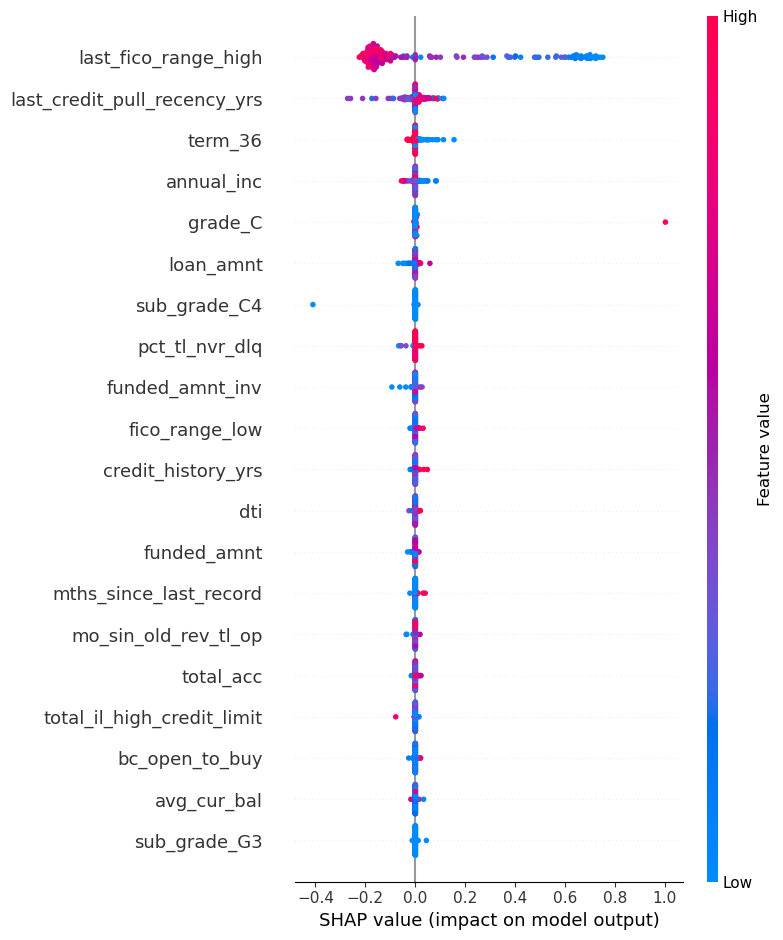

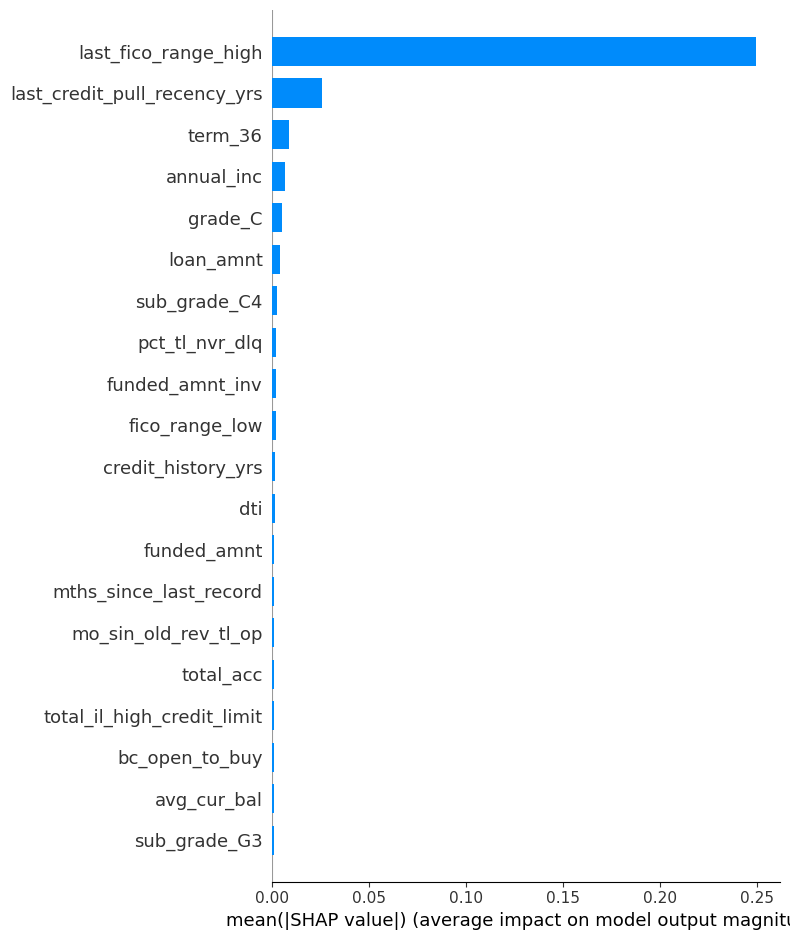

In [58]:
# === SHAP explainability for tuned XGBoost using KernelExplainer ===
import shap
import numpy as np

shap.initjs()

# best_xgb: tuned XGBoost model trained on X_train_proc
# X_train_proc: numpy array from numeric_preprocessor

# 1) Choose a background sample for SHAP (to approximate the distribution)
#    We subsample to keep it tractable.
background_size = min(500, X_train_proc.shape[0])
background_idx = np.random.choice(X_train_proc.shape[0], size=background_size, replace=False)
background = X_train_proc[background_idx]

# 2) Define a prediction function returning probabilities for the positive class
def xgb_predict_proba(data):
    # data will be a numpy array with the same columns as X_train_proc
    return best_xgb.predict_proba(data)[:, 1]

# 3) Build KernelExplainer (model-agnostic SHAP)
explainer_xgb = shap.KernelExplainer(xgb_predict_proba, background)

# 4) Take a sample of the training data to explain
sample_size = min(200, X_train_proc.shape[0])
X_sample = X_train_proc[:sample_size]

# Compute SHAP values for the sample
shap_values_sample = explainer_xgb.shap_values(X_sample, nsamples=100)

# Bee swarm (summary) plot – top 20 features
shap.summary_plot(
    shap_values_sample,
    X_sample,
    feature_names=X_full.columns,
    max_display=20,
    plot_type="dot"
)

# Bar plot of mean |SHAP| values – top 20 features
shap.summary_plot(
    shap_values_sample,
    X_sample,
    feature_names=X_full.columns,
    max_display=20,
    plot_type="bar"
)


## 9. ANN model (baseline features)

In [59]:
input_dim = X_train_proc.shape[1]
input_dim

155

In [60]:
def build_ann_model(input_dim, units1=128, units2=64, dropout_rate=0.3, lr=1e-3):
    model = keras.Sequential(
        [
            layers.Input(shape=(input_dim,)),
            layers.Dense(units1, activation="relu"),
            layers.Dropout(dropout_rate),
            layers.Dense(units2, activation="relu"),
            layers.Dropout(dropout_rate),
            layers.Dense(1, activation="sigmoid"),
        ]
    )
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy", keras.metrics.AUC(name="auc")],
    )
    return model

configs = [
    {"name": "ANN_64_32", "units1": 64, "units2": 32, "dropout": 0.3, "lr": 1e-3},
    {"name": "ANN_128_64", "units1": 128, "units2": 64, "dropout": 0.3, "lr": 1e-3},
    {"name": "ANN_128_64_lr_small", "units1": 128, "units2": 64, "dropout": 0.3, "lr": 5e-4},
]

best_ann_result = None
best_ann_name = None

for cfg in configs:
    print(f"\n===== Training {cfg['name']} =====")
    ann = build_ann_model(
        input_dim=input_dim,
        units1=cfg["units1"],
        units2=cfg["units2"],
        dropout_rate=cfg["dropout"],
        lr=cfg["lr"],
    )
    history = ann.fit(
        X_train_proc,
        y_train,
        epochs=15,
        batch_size=512,
        validation_split=0.2,
        verbose=0,  # set to 1 if you want epoch logs
    )

    y_proba_ann = ann.predict(X_test_proc).ravel()
    y_pred_ann = (y_proba_ann >= 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred_ann)
    prec = precision_score(y_test, y_pred_ann)
    rec = recall_score(y_test, y_pred_ann)
    f1 = f1_score(y_test, y_pred_ann)
    pr_auc = average_precision_score(y_test, y_proba_ann)

    print(f"{cfg['name']} -> acc={acc:.4f}, prec={prec:.4f}, rec={rec:.4f}, f1={f1:.4f}, pr_auc={pr_auc:.4f}")

    this_result = {
        "model": cfg["name"],
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "pr_auc": pr_auc,
    }

    if (best_ann_result is None) or (pr_auc > best_ann_result["pr_auc"]):
        best_ann_result = this_result
        best_ann_name = cfg["name"]

print("\nBest ANN configuration:", best_ann_name)
best_ann_result


===== Training ANN_64_32 =====
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
ANN_64_32 -> acc=0.9422, prec=0.8720, rec=0.8067, f1=0.8381, pr_auc=0.9137

===== Training ANN_128_64 =====
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 1s 288us/step
ANN_128_64 -> acc=0.9417, prec=0.8704, rec=0.8058, f1=0.8369, pr_auc=0.9145

===== Training ANN_128_64_lr_small =====
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 1s 288us/step
ANN_128_64_lr_small -> acc=0.9415, prec=0.8677, rec=0.8082, f1=0.8369, pr_auc=0.9126

Best ANN configuration: ANN_128_64


{'model': 'ANN_128_64',
 'accuracy': 0.9417016047419402,
 'precision': 0.870411275901967,
 'recall': 0.8058233518356218,
 'f1': 0.8368729773462783,
 'pr_auc': 0.9144941191071231}

## 10. XGBoost sensitivity to FICO and grade

In [61]:
# 10. XGBoost sensitivity to FICO and LendingClub grade

# --- identify FICO- and grade-related columns after all engineering ---
fico_cols = [c for c in X_full.columns if "fico" in c.lower()]

# anything with "grade" or "sub_grade" in the name, but not FICO
grade_cols = [
    c for c in X_full.columns
    if (("grade" in c.lower()) or ("sub_grade" in c.lower()))
    and ("fico" not in c.lower())
]

print("FICO-related columns:", fico_cols)
print("\nGrade / sub-grade-related columns:", grade_cols)
print("Number of grade/sub-grade columns:", len(grade_cols))

# --- helper: build feature matrix with optional drops ---
def build_feature_matrix(drop_fico: bool = False, drop_grade: bool = False):
    cols = list(X_full.columns)

    if drop_fico and fico_cols:
        cols = [c for c in cols if c not in fico_cols]

    if drop_grade and grade_cols:
        cols = [c for c in cols if c not in grade_cols]

    X_sub = X_full[cols].copy()

    Xtr, Xte, ytr, yte = train_test_split(
        X_sub, y, test_size=0.2, random_state=42, stratify=y
    )

    # reuse the same numeric_preprocessor from Section 6
    Xtr_p = numeric_preprocessor.fit_transform(Xtr)
    Xte_p = numeric_preprocessor.transform(Xte)

    return Xtr_p, Xte_p, ytr, yte

# --- helper: run XGBoost with the sensitivity setting ---
def run_xgb_sensitivity(drop_fico: bool = False, drop_grade: bool = False):
    Xtr_p, Xte_p, ytr, yte = build_feature_matrix(
        drop_fico=drop_fico, drop_grade=drop_grade
    )

    model = XGBClassifier(
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        tree_method="hist",
        random_state=42,
    )

    return eval_model(
        f"XGBoost (drop_fico={drop_fico}, drop_grade={drop_grade})",
        model,
        Xtr_p,
        ytr,
        Xte_p,
        yte,
    )

# --- run all four scenarios ---
results_sens = []
results_sens.append(run_xgb_sensitivity(drop_fico=False, drop_grade=False))
results_sens.append(run_xgb_sensitivity(drop_fico=True, drop_grade=False))
results_sens.append(run_xgb_sensitivity(drop_fico=False, drop_grade=True))
results_sens.append(run_xgb_sensitivity(drop_fico=True, drop_grade=True))

pd.DataFrame(results_sens)


FICO-related columns: ['fico_range_low', 'fico_range_high', 'last_fico_range_high', 'last_fico_range_low']

Grade / sub-grade-related columns: ['grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G', 'grade_Missing', 'sub_grade_A2', 'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5', 'sub_grade_Missing']
Number of grade/sub-grade columns: 42

=== XGBoost (drop_fico=False, drop_grade=False) ===
Accuracy : 0.9463
Precision: 0.8726
Recall   : 0.8318
F1-score : 0.8517
PR AUC   : 0.9228
Confusion matrix (rows=true

,model,accuracy,precision,recall,f1,pr_auc
0,"XGBoost (drop_fico=False, drop_grade=False)",0.946256,0.872612,0.831824,0.851730,0.922821
1,"XGBoost (drop_fico=True, drop_grade=False)",0.821834,0.589364,0.131658,0.215235,0.431182
2,"XGBoost (drop_fico=False, drop_grade=True)",0.946039,0.871014,0.832506,0.851324,0.922744
3,"XGBoost (drop_fico=True, drop_grade=True)",0.822015,0.590752,0.133119,0.217277,0.432833


In [62]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
)
import joblib

# Same simple feature set for deployment
deploy_features = [
    "loan_amnt",
    "int_rate",
    "annual_inc",
    "dti",
    "fico_range_low",
    "fico_range_high",
    "term_36",
]

for f in deploy_features:
    if f not in loan_data.columns:
        raise ValueError(f"Deploy feature {f} not found in loan_data columns!")

X_deploy = loan_data[deploy_features].copy()
y_deploy = loan_data["loan_status"].values  # 0/1 target

X_train_web, X_test_web, y_train_web, y_test_web = train_test_split(
    X_deploy, y_deploy, test_size=0.2, random_state=42, stratify=y_deploy
)

web_pipeline_lr = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        (
            "model",
            LogisticRegression(
                max_iter=1000,
                class_weight="balanced",
                solver="lbfgs",
            ),
        ),
    ]
)

web_pipeline_lr.fit(X_train_web, y_train_web)

y_proba_web = web_pipeline_lr.predict_proba(X_test_web)[:, 1]
y_pred_web = (y_proba_web >= 0.5).astype(int)

acc_web = accuracy_score(y_test_web, y_pred_web)
prec_web = precision_score(y_test_web, y_pred_web)
rec_web = recall_score(y_test_web, y_pred_web)
f1_web = f1_score(y_test_web, y_pred_web)
pr_auc_web = average_precision_score(y_test_web, y_proba_web)

print("=== Web Deployment Model (Logistic Regression) ===")
print(f"Accuracy : {acc_web:0.4f}")
print(f"Precision: {prec_web:0.4f}")
print(f"Recall   : {rec_web:0.4f}")
print(f"F1-score : {f1_web:0.4f}")
print(f"PR AUC   : {pr_auc_web:0.4f}")

print("\nFeatures used for deployment model:")
print(deploy_features)

# Save this lighter model
joblib.dump(web_pipeline_lr, "web_pipeline_lr.pkl")
print("\nSaved web deployment pipeline to web_pipeline_lr.pkl")


=== Web Deployment Model (Logistic Regression) ===
Accuracy : 0.6447
Precision: 0.2911
Recall   : 0.6372
F1-score : 0.3996
PR AUC   : 0.3272

Features used for deployment model:
['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'fico_range_low', 'fico_range_high', 'term_36']

Saved web deployment pipeline to web_pipeline_lr.pkl


## 11. Notes for Presentation
- Use the baseline metrics table to compare Random Forest, AdaBoost, XGBoost, and ANN.
- Use the sensitivity table to discuss how performance changes when FICO and/or grade are removed.
- Summarise: data cleaning, feature engineering, model comparison, and business interpretation.